In [7]:
# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# Standardize the data (padronização)
from sklearn.preprocessing import StandardScaler

# Modeling 
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/dataset_macau.csv')
# df = pd.read_csv('C:\projetos\jupyter_notebook\hyperparams_optimization\_data\dataset_macau.csv')
# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df.Data = pd.to_datetime(df.Data)

# Tranformando a coluna "Data" em index
df.set_index('Data', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,Velocidade,Temperatura,Umidade,Pressão,Direção
Data,,,,,
2004-01-01,6.33,29.13,67.67,1010.97,11.00
2004-01-02,4.63,29.47,70.33,1010.67,5.67
2004-01-03,5.47,29.00,73.00,1010.20,7.67
2004-01-04,7.97,30.00,70.00,1009.57,10.67
2004-01-05,6.73,29.60,67.67,1009.03,11.00


In [9]:
df = df.drop(columns=['Temperatura','Umidade','Pressão','Direção'])
df

,Velocidade
Data,
2004-01-01,6.33
2004-01-02,4.63
2004-01-03,5.47
2004-01-04,7.97
2004-01-05,6.73
...,...
2017-05-27,3.76
2017-05-28,8.64
2017-05-29,8.88


Text(0, 0.5, 'Velocidade m/s²')

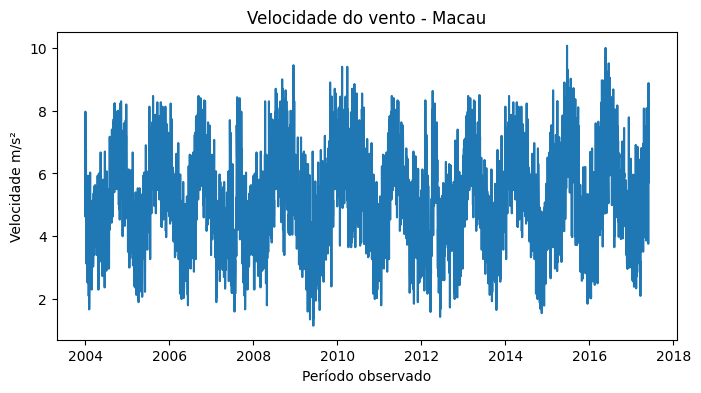

In [10]:
plt.subplots(figsize=(8,4))
plt.plot(df)
plt.title('Velocidade do vento - Macau')
plt.xlabel('Período observado')
plt.ylabel('Velocidade m/s²')

## Pré-processamento
> Separação dos dados em treino / teste

In [11]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [12]:
train, test = split_dataset(df, 0.75, True)


BASE DE TREINO
             Velocidade
Data                  
2014-01-18        4.87
2014-01-19        4.73
2014-01-20        6.87
2014-01-21        6.10
2014-01-22        7.40

BASE DE TESTE
             Velocidade
Data                  
2014-01-23        7.10
2014-01-24        7.10
2014-01-25        7.63
2014-01-26        5.53
2014-01-27        6.70


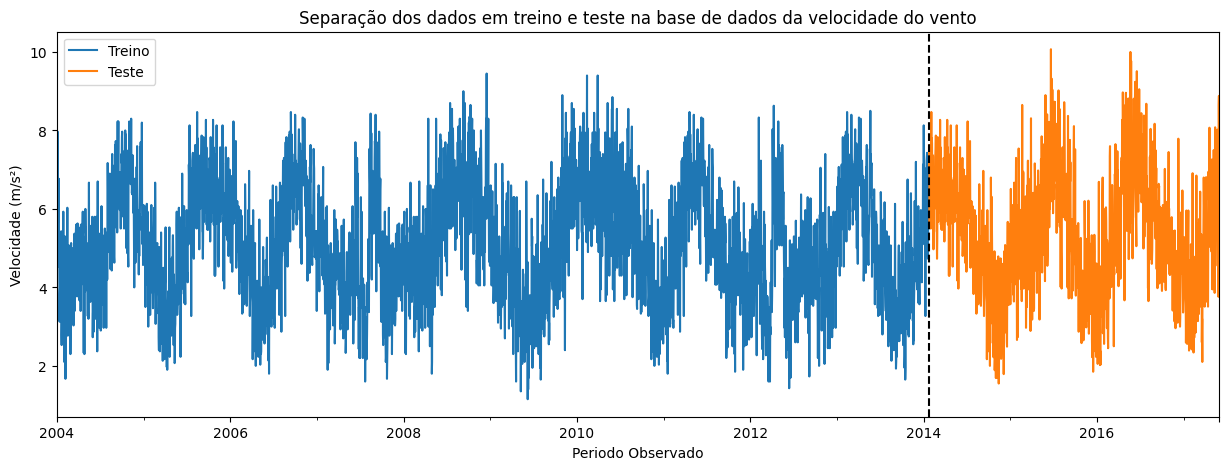

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Treino', title='Separação dos dados em treino e teste na base de dados da velocidade do vento')
test.plot(ax=ax, label='Teste')
ax.axvline('2014-01-22', color='black', ls='--')
ax.legend(['Treino', 'Teste'])
plt.xlabel("Periodo Observado")
plt.ylabel("Velocidade (m/s²)")
plt.show()

> Feature Engineering

In [14]:
def series_to_supervised_lag(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:] # remove linhas iniciais com nan
    return features

### Plotagem  das Previsões

In [15]:
def predict_svr(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale', lag=1):

    # Criação dos Lags
    steps_in = lag
    train_data_features = series_to_supervised_lag(train, steps_in)
    test_data_features = series_to_supervised_lag(test, steps_in)

    # Definição de X e y
    X_train = train_data_features.drop(columns=['t']).values
    y_train = train_data_features['t'].values.reshape(-1, 1)
    X_test = test_data_features.drop(columns=['t']).values
    y_test = test_data_features['t'].values.reshape(-1, 1)

    # Inicializa a padronização
    sc = StandardScaler()
    X_train_transformed = pd.DataFrame(sc.fit_transform(X_train))
    X_test_transformed = pd.DataFrame(sc.transform(X_test))

    # treina o modelo
    svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train_transformed, y_train)
    predictions = svr.predict(X_test_transformed)

    # adicionando as datas
    previsao = pd.DataFrame(test_data_features['t'])
    previsao = previsao.drop(columns=['t'])
    previsao['validacao'] = y_test
    previsao['previsao'] = predictions
    previsao
        
    # calculo do erro
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)

    fig = plt.subplots(figsize=(10,4))
    # plt.plot(y_test[:100], label='Validação')
    plt.plot(previsao['validacao'][:100], label='Validação')
    plt.plot(previsao['previsao'][:100], '--', label='Previsão')
    plt.title('Previsão direta para a velocidade do vento (Macau) - MSE: {:.3f} || RMSE: {:.3f}'.format(mse, rmse))
    plt.xlabel('Periodo Observado')
    plt.ylabel('Velocidade m/s²')
    plt.legend()
    plt.tight_layout()

    return previsao, rmse, mse

> Bayes Search

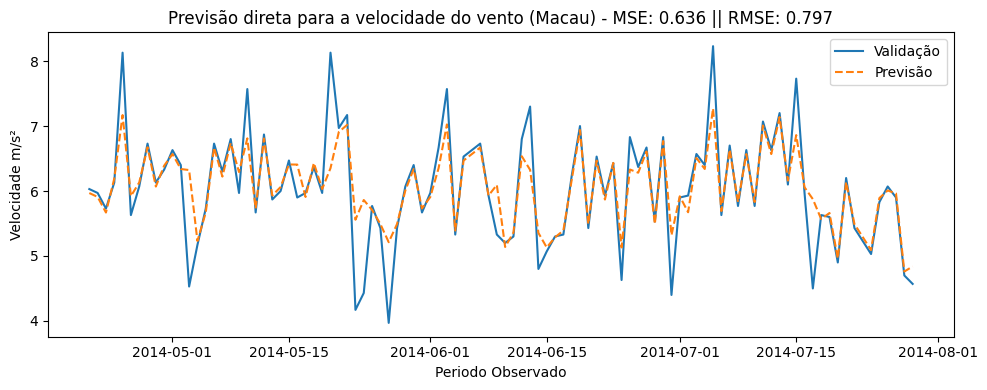

In [16]:
previsao_bs, rmse_bs, mse_bs = predict_svr(C=5.202, epsilon=0.061, lag=88)

> Random Search

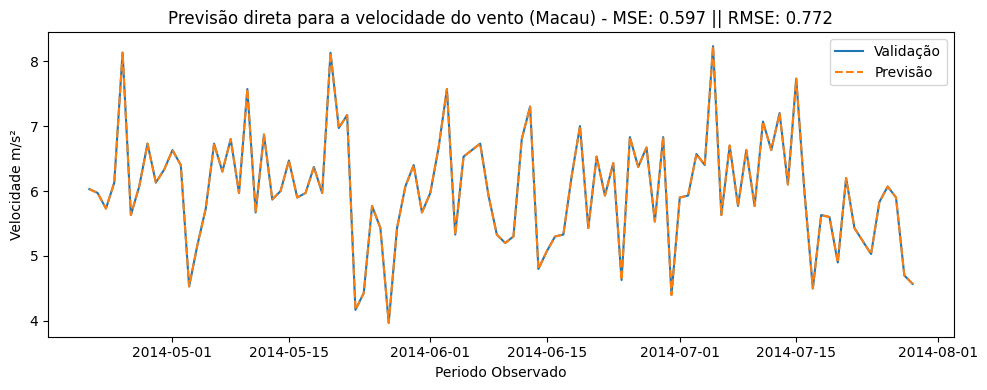

In [17]:
previsao_rs, rmse_rs, mse_rs = predict_svr(C=31.622776601683793, epsilon=1e-05, lag=88)

> Ajustando a previsão

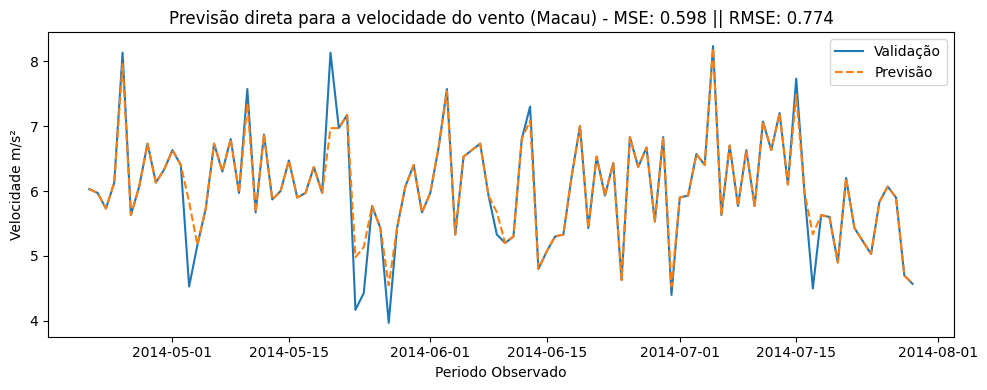

In [18]:
previsao, rmse, mse = predict_svr(C=10.0, epsilon=1e-5, lag=88)

[DatetimeIndex(['2014-04-21', '2014-04-22', '2014-04-23', '2014-04-24',
               '2014-04-25', '2014-04-26', '2014-04-27', '2014-04-28',
               '2014-04-29', '2014-04-30',
               ...
               '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25',
               '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29',
               '2017-05-30', '2017-05-31'],
              dtype='datetime64[ns]', name='Data', length=1137, freq=None)]


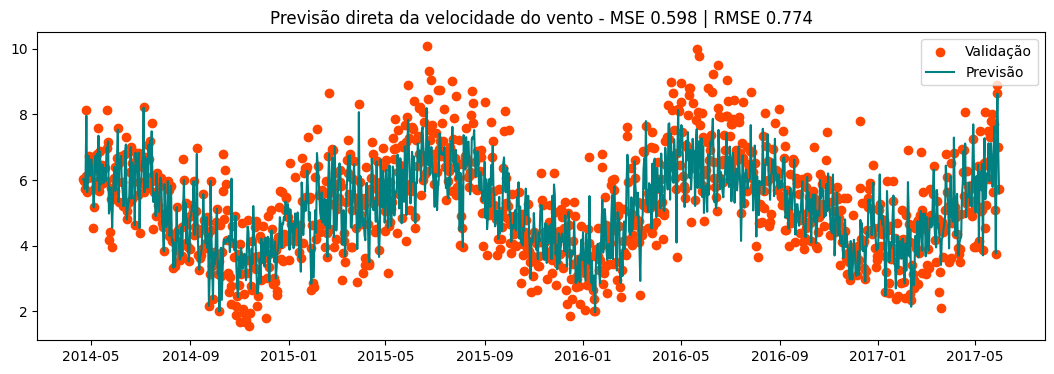

In [19]:
date = []
date.append(pd.DataFrame(previsao).index)
print(date)

fig = plt.subplots(figsize=(13, 4))
plt.scatter(date, previsao['validacao'], label='Validação', color='orangered')
plt.plot(previsao['previsao'], label='Previsão', color='teal')
plt.title(f'Previsão direta da velocidade do vento - MSE {mse:.3f} | RMSE {rmse:.3f}')
plt.legend()

In [20]:
compare_prev = pd.DataFrame()
compare_prev['bayes-search'] = pd.DataFrame(previsao_bs['previsao'])
compare_prev['random-search'] = pd.DataFrame(previsao_rs['previsao'])
compare_prev

,bayes-search,random-search
Data,,
2014-04-21,5.968998,6.029805
2014-04-22,5.908923,5.969795
2014-04-23,5.668955,5.730184
2014-04-24,6.191054,6.130189
2014-04-25,7.168904,8.130030
...,...,...
2017-05-27,3.967500,3.705435
2017-05-28,7.474641,7.591768
2017-05-29,8.462117,8.679017


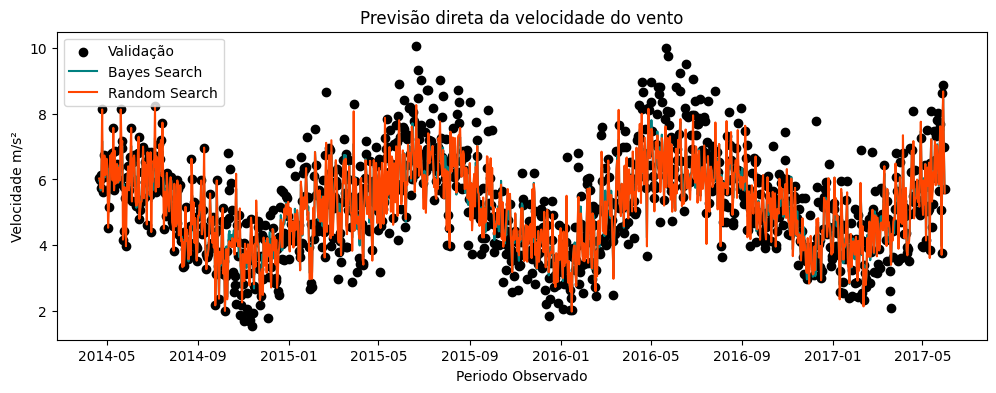

In [21]:
fig = plt.subplots(figsize=(12, 4))
plt.scatter(date, previsao['validacao'], label='Validação', color='black')
plt.plot(compare_prev['bayes-search'], label='Bayes Search', color='teal')
plt.plot(compare_prev['random-search'], label='Random Search', color='orangered')
# plt.title(f'Previsão direta da velocidade do vento\nBayes Search: MSE {mse_bs:.3f} e RMSE {rmse_bs:.3f} || Random Search: MSE {mse_rs:.3f} e RMSE {rmse_rs:.3f}')
plt.title('Previsão direta da velocidade do vento')
plt.legend()
plt.xlabel('Periodo Observado')
plt.ylabel('Velocidade m/s²')
plt.show()

### PLotagem da previsão iterativa (Passo a Passo)

In [22]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

def series_to_supervised(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['target+'+str(i)] = serie.shift(-i)
    features = features.dropna() # remove linhas iniciais com nan
    return features

In [23]:
# train_set, test_set = split_dataset(df, 0.75, False)

# train_data_features = series_to_supervised(serie=train_set, steps_in=1)
# test_data_features = series_to_supervised(serie=test_set, steps_in=1)

# X_train = train_data_features.drop(columns=['target+'+str(1)]).values
# y_train = train_data_features.iloc[:,[1]].values
# X_test = test_data_features.drop(columns=['target+'+str(1)]).values
# y_test = test_data_features.iloc[:,[1]].values

# # Inicializa a padronização
# sc = StandardScaler()
# X_train_transformed = pd.DataFrame(sc.fit_transform(X_train))
# X_test_transformed = pd.DataFrame(sc.transform(X_test))

# # treina o modelo
# svr = SVR(C=1, epsilon=0.1, gamma='scale')
# svr.fit(X_train_transformed, y_train)

# predict = []
# for i in range(12):
#     pred = svr.predict([X_test_transformed.values[i]])
#     print('Predito: {} || Validação: {}'.format(pred[0], X_test_transformed.values[i]))

In [24]:
def fit_predict_steps(passos=1, C=1.0, epsilon=0.1, gamma=1.0):
    train_set, test_set = split_dataset(df, 0.75, False)

    # Inicializa a padronização
    sc = StandardScaler()

    predicted = []
    yTrue = []
    mae_error = []
    mse_error = []
    rmse_error = []

    for i in range(1, passos+1):
        train_data_features = series_to_supervised(serie=train_set, steps_in=i)
        test_data_features = series_to_supervised(serie=test_set, steps_in=i)

        X_train = train_data_features.drop(columns=['target+'+str(i)]).values
        y_train = train_data_features.iloc[:,[i]].values
        X_test = test_data_features.drop(columns=['target+'+str(i)]).values
        y_test = test_data_features.iloc[:,[i]].values

        # padronização
        X_train_transformed = pd.DataFrame(sc.fit_transform(X_train))
        X_test_transformed = pd.DataFrame(sc.transform(X_test))

        # treina o modelo
        svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
        svr.fit(X_train_transformed, y_train)

        pred = svr.predict([X_test_transformed.values[0]])
        true = y_test[0]
        mae = mean_absolute_error(pred, true)
        mse = mean_squared_error(pred, true)
        rmse = np.sqrt(mean_squared_error(pred, true))

        print('[{}] Real: {} || Predito: {} || MAE: {} => SVR(C={}, epsilon={}, gamma={})'.format(i, true, pred, mae, C, epsilon, gamma))

        predicted.append(pred)
        yTrue.append(true)
        mae_error.append(mae)
        mse_error.append(mse)
        rmse_error.append(rmse)

    previsao = pd.DataFrame(test_data_features.t[:12])
    previsao = previsao.drop(columns=['t'])
    previsao['validacao'] = yTrue
    previsao['previsao'] = predicted
    previsao['RMSE'] = rmse_error
    previsao['MSE'] = mse_error
    # previsao

    # return predicted, yTrue, mae_error, mse_error
    return previsao

In [25]:
def plot_result(predictions1, legenda1, predictions2, legenda2, y_true, mae=0, mse=0, rmse=0, title='', xlabel=''):
    train_set, test_set = split_dataset(df, 0.75, False)
    fig = plt.subplots(figsize=(8,4))
    plt.plot(train_set[len(train_set)-40:])
    plt.plot(y_true)
    plt.plot(predictions1, '--')
    plt.plot(predictions2, '--')
    if (mae != 0) | (mse != 0) | (rmse != 0):
        plt.title(f'{title}\nMSE: {mse:.3f} || RMSE: {rmse:.3f} || MAE: {mae:.3f}')
    else:
        plt.title(f'{title}')
    plt.xlabel('Periodo Observado')
    plt.ylabel(xlabel)
    plt.legend(['Treinamento','Validação',legenda1,legenda2])
    plt.tight_layout()

In [26]:
pred_bs = fit_predict_steps(passos=12, C=5.202, epsilon=0.061)

BASE DE TREINO:  3675
BASE DE TESTE:   1225
[1] Real: [7.1] || Predito: [6.5754797] || MAE: 0.5245203042368356 => SVR(C=5.202, epsilon=0.061, gamma=1.0)
[2] Real: [7.63] || Predito: [6.72647957] || MAE: 0.9035204344679482 => SVR(C=5.202, epsilon=0.061, gamma=1.0)
[3] Real: [5.53] || Predito: [7.16094315] || MAE: 1.6309431519992401 => SVR(C=5.202, epsilon=0.061, gamma=1.0)
[4] Real: [6.7] || Predito: [5.90109048] || MAE: 0.7989095216431723 => SVR(C=5.202, epsilon=0.061, gamma=1.0)
[5] Real: [7.47] || Predito: [7.53104275] || MAE: 0.061042746759076394 => SVR(C=5.202, epsilon=0.061, gamma=1.0)
[6] Real: [6.27] || Predito: [6.62040785] || MAE: 0.35040784962123617 => SVR(C=5.202, epsilon=0.061, gamma=1.0)
[7] Real: [7.] || Predito: [6.93886248] || MAE: 0.061137517124320695 => SVR(C=5.202, epsilon=0.061, gamma=1.0)
[8] Real: [5.5] || Predito: [5.56049937] || MAE: 0.06049936954904833 => SVR(C=5.202, epsilon=0.061, gamma=1.0)
[9] Real: [7.33] || Predito: [7.26943015] || MAE: 0.0605698525907349

In [27]:
pred_bs

,validacao,previsao,RMSE,MSE
Data,,,,
2014-01-23,[7.1],[6.575479695763164],0.524520,0.275122
2014-01-24,[7.63],[6.726479565532052],0.903520,0.816349
2014-01-25,[5.53],[7.16094315199924],1.630943,2.659976
2014-01-26,[6.7],[5.901090478356828],0.798910,0.638256
2014-01-27,[7.47],[7.531042746759076],0.061043,0.003726
2014-01-28,[6.27],[6.620407849621236],0.350408,0.122786
2014-01-29,[7.0],[6.938862482875679],0.061138,0.003738
2014-01-30,[5.5],[5.560499369549048],0.060499,0.003660
2014-01-31,[7.33],[7.269430147409265],0.060570,0.003669


In [28]:
pred_bs

,validacao,previsao,RMSE,MSE
Data,,,,
2014-01-23,[7.1],[6.575479695763164],0.524520,0.275122
2014-01-24,[7.63],[6.726479565532052],0.903520,0.816349
2014-01-25,[5.53],[7.16094315199924],1.630943,2.659976
2014-01-26,[6.7],[5.901090478356828],0.798910,0.638256
2014-01-27,[7.47],[7.531042746759076],0.061043,0.003726
2014-01-28,[6.27],[6.620407849621236],0.350408,0.122786
2014-01-29,[7.0],[6.938862482875679],0.061138,0.003738
2014-01-30,[5.5],[5.560499369549048],0.060499,0.003660
2014-01-31,[7.33],[7.269430147409265],0.060570,0.003669


In [29]:
pred_rs = fit_predict_steps(passos=12, C=31.623, epsilon=1e-05, gamma=4.641588833612773e-06)

BASE DE TREINO:  3675
BASE DE TESTE:   1225
[1] Real: [7.1] || Predito: [5.61852476] || MAE: 1.4814752424515163 => SVR(C=31.623, epsilon=1e-05, gamma=4.641588833612773e-06)
[2] Real: [7.63] || Predito: [5.93160481] || MAE: 1.6983951894790925 => SVR(C=31.623, epsilon=1e-05, gamma=4.641588833612773e-06)
[3] Real: [5.53] || Predito: [6.23250714] || MAE: 0.702507138382102 => SVR(C=31.623, epsilon=1e-05, gamma=4.641588833612773e-06)
[4] Real: [6.7] || Predito: [6.02521285] || MAE: 0.6747871512924144 => SVR(C=31.623, epsilon=1e-05, gamma=4.641588833612773e-06)
[5] Real: [7.47] || Predito: [6.1544486] || MAE: 1.3155514007018896 => SVR(C=31.623, epsilon=1e-05, gamma=4.641588833612773e-06)
[6] Real: [6.27] || Predito: [6.30079264] || MAE: 0.030792637559446945 => SVR(C=31.623, epsilon=1e-05, gamma=4.641588833612773e-06)
[7] Real: [7.] || Predito: [6.24847152] || MAE: 0.7515284842927326 => SVR(C=31.623, epsilon=1e-05, gamma=4.641588833612773e-06)
[8] Real: [5.5] || Predito: [6.3999605] || MAE: 0.

In [30]:
pred_rs

,validacao,previsao,RMSE,MSE
Data,,,,
2014-01-23,[7.1],[5.618524757548483],1.481475,2.194769
2014-01-24,[7.63],[5.931604810520907],1.698395,2.884546
2014-01-25,[5.53],[6.232507138382102],0.702507,0.493516
2014-01-26,[6.7],[6.025212848707586],0.674787,0.455338
2014-01-27,[7.47],[6.15444859929811],1.315551,1.730675
2014-01-28,[6.27],[6.3007926375594465],0.030793,0.000948
2014-01-29,[7.0],[6.248471515707267],0.751528,0.564795
2014-01-30,[5.5],[6.399960502514721],0.899961,0.809929
2014-01-31,[7.33],[6.17418239275628],1.155818,1.335914


BASE DE TREINO:  3675
BASE DE TESTE:   1225


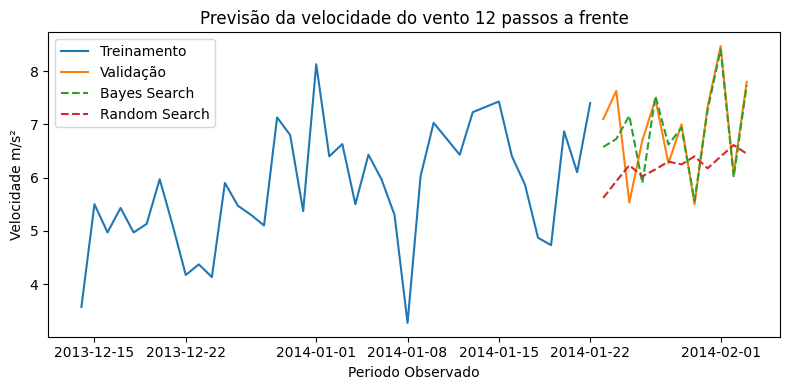

In [31]:
plot_result(predictions1=pred_bs['previsao'], legenda1='Bayes Search', predictions2=pred_rs['previsao'], legenda2='Random Search', y_true=pred_rs['validacao'], title='Previsão da velocidade do vento 12 passos a frente', xlabel='Velocidade m/s²')

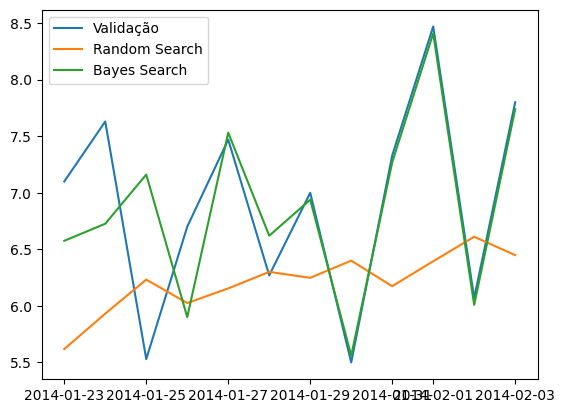

In [32]:
plt.plot(pred_rs['validacao'], label='Validação')
plt.plot(pred_rs['previsao'], label='Random Search')
plt.plot(pred_bs['previsao'], label='Bayes Search')
plt.legend()

### Ajuste das previsões para comparação

In [33]:
train_set, test_set = split_dataset(df, 0.75, False)

train_data_features = series_to_supervised(serie=train_set, steps_in=1)
test_data_features = series_to_supervised(serie=test_set, steps_in=1)
# train_data_features[len(train_data_features)-10:]
train_data_features['t'][len(train_data_features)-5:]

BASE DE TREINO:  3675
BASE DE TESTE:   1225


Data
2014-01-17    5.87
2014-01-18    4.87
2014-01-19    4.73
2014-01-20    6.87
2014-01-21    6.10
Name: t, dtype: float64

In [34]:
pred_bs['previsao']

Data
2014-01-23    [6.575479695763164]
2014-01-24    [6.726479565532052]
2014-01-25     [7.16094315199924]
2014-01-26    [5.901090478356828]
2014-01-27    [7.531042746759076]
2014-01-28    [6.620407849621236]
2014-01-29    [6.938862482875679]
2014-01-30    [5.560499369549048]
2014-01-31    [7.269430147409265]
2014-02-01    [8.408828816707388]
2014-02-02    [6.008976437913301]
2014-02-03    [7.739306433382431]
Name: previsao, dtype: object

In [35]:
test_set[:12]

,Velocidade
Data,
2014-01-23,7.10
2014-01-24,7.10
2014-01-25,7.63
2014-01-26,5.53
2014-01-27,6.70
2014-01-28,7.47
2014-01-29,6.27
2014-01-30,7.00
2014-01-31,5.50


In [36]:
# pred_bs['previsao'].values
svm_bs = []
svm_rs = []
for p in pred_bs['previsao'].values:
    svm_bs.append(round(p[0],2))

for p in pred_rs['previsao'].values:
    svm_rs.append(round(p[0],2))

In [37]:
# arima = [6.68, 6.53, 6.73, 7.10, 6.06, 6.59, 6.51, 6.45, 6.89, 5.98, 6.56, 7.36]
# arima = [6.678926,6.509377,6.697564,7.057864,6.040533,6.554714,6.468066,6.421047,6.864818,5.961413,6.565624,7.362691]

arima = [6.68, 6.53, 6.73, 7.10, 6.06, 6.59, 6.51, 6.45, 6.86, 5.98, 6.56, 7.36]

prev_final = test_set[:12]
prev_final['arima'] = arima
prev_final['svm_bs'] = svm_bs
prev_final['svm_rs'] = svm_rs
prev_final['validacao'] = pred_bs['validacao']
prev_final

,Velocidade,arima,svm_bs,svm_rs,validacao
Data,,,,,
2014-01-23,7.10,6.68,6.58,5.62,[7.1]
2014-01-24,7.10,6.53,6.73,5.93,[7.63]
2014-01-25,7.63,6.73,7.16,6.23,[5.53]
2014-01-26,5.53,7.10,5.90,6.03,[6.7]
2014-01-27,6.70,6.06,7.53,6.15,[7.47]
2014-01-28,7.47,6.59,6.62,6.30,[6.27]
2014-01-29,6.27,6.51,6.94,6.25,[7.0]
2014-01-30,7.00,6.45,5.56,6.40,[5.5]
2014-01-31,5.50,6.86,7.27,6.17,[7.33]


In [38]:
print('ARIMA: ',np.sqrt(mean_squared_error(prev_final['Velocidade'], prev_final['arima'])))

print("\nRMSE")
print('SVM BS: ',np.sqrt(mean_squared_error(prev_final['Velocidade'], prev_final['svm_bs'])))
print('SVM RS: ',np.sqrt(mean_squared_error(prev_final['Velocidade'], prev_final['svm_rs'])))

print("\nMSE")
print('SVM BS: ',mean_squared_error(prev_final['Velocidade'], prev_final['svm_bs']))
print('SVM RS: ',mean_squared_error(prev_final['Velocidade'], prev_final['svm_rs']))

ARIMA:  1.0918104231046706

RMSE
SVM BS:  1.219248402363795
SVM RS:  1.0302750441831863

MSE
SVM BS:  1.4865666666666668
SVM RS:  1.0614666666666666


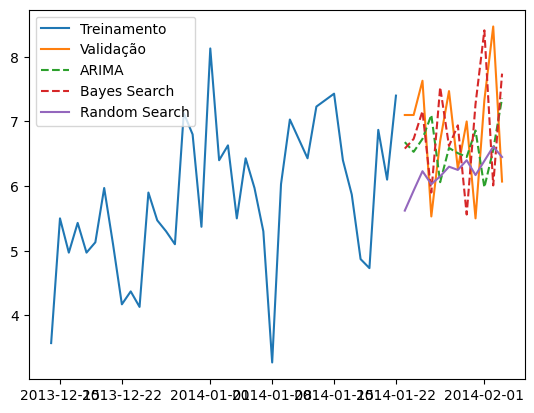

In [39]:
plt.plot(train_set[len(train_set)-40:], label='Treinamento')
plt.plot(test_set[:12], label='Validação')
# plt.plot(pred_bs['validacao'])
plt.plot(prev_final['arima'], '--', label='ARIMA')
plt.plot(prev_final['svm_bs'], '--', label='Bayes Search')
plt.plot(prev_final['svm_rs'], label='Random Search')
plt.legend()

In [40]:
print('ARIMA: ',np.sqrt(mean_squared_error(prev_final['validacao'], prev_final['arima'])))

print("\nRMSE")
print('SVM BS: ',np.sqrt(mean_squared_error(prev_final['validacao'], prev_final['svm_bs'])))
print('SVM RS: ',np.sqrt(mean_squared_error(prev_final['validacao'], prev_final['svm_rs'])))

print("\nMSE")
print('SVM BS: ',mean_squared_error(prev_final['validacao'], prev_final['svm_bs']))
print('SVM RS: ',mean_squared_error(prev_final['validacao'], prev_final['svm_rs']))

ARIMA:  1.0437991505393491

RMSE
SVM BS:  0.6140711142313513
SVM RS:  1.187476315553283

MSE
SVM BS:  0.37708333333333327
SVM RS:  1.4101000000000001


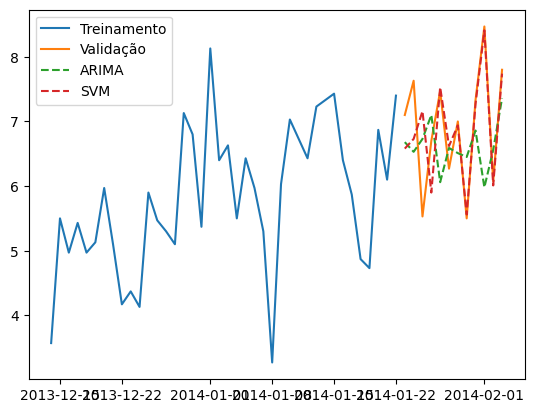

In [41]:
plt.plot(train_set[len(train_set)-40:], label='Treinamento')
plt.plot(prev_final['validacao'], label='Validação')
plt.plot(prev_final['arima'], '--', label='ARIMA')
plt.plot(prev_final['svm_bs'], '--', label='SVM')
plt.legend()